First, we load up some useful libraries for visualization and data structures.

In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.axes as axes
import copy
import random

Next we need a Maze class for pathfinding. It will help to have read the RedBlobGames [A\* tutorial](http://www.redblobgames.com/pathfinding/a-star/introduction.html) before continuing.

These Mazes are defined in ASCII diagrams and can have walls ("#"), empty spaces ("."), switches (numbers), and doors (letters; closed are uppercase). The "0" switch toggles the open status of all the "a" doors, "1" goes to the "b" doors, etc. Mazes can also contain pits: "?" pits have a 30% chance of killing the player and "!" pits have a 60% chance. Every maze has one player start location "@" and one goal square "X". Walls and closed doors block movement.

[(1, 0), (0, -1), (0, 1), 'switch']


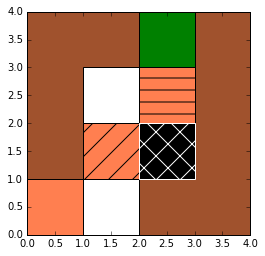

In [4]:
class Maze:
    SwitchMap = {"0":"a", "1":"b", "2":"c", "3":"d", "4":"e", "5":"f", "6":"g", "7":"h", "8":"i", "9":"j"}
    Colors = {"a":"coral","b":"tan","c":"palegreen","d":"blue","e":"cyan","f":"magenta","g":"yellow","h":"olive","i":"purple","j":"darkgreen",
              "0":"coral","1":"tan","2":"palegreen","3":"blue","4":"cyan","5":"magenta","6":"yellow","7":"olive","8":"purple","9":"darkgreen",
             "?":"orange",
             "!":"red",
             "x":"green","@":"gray",
             "#":"sienna",".":"white"}
    
    def __init__(self,rows):
        self.grid = [list(r) for r in rows]
        self.grid.reverse()
        height = len(self.grid)
        width = len(self.grid[0])
        self.exit_pos = None
        self.player_pos = None
        self.player_alive = True
        for y in range(0,height):
            assert len(self.grid[y]) == width, "All rows must be equal length!"
            for x in range(0,width):
                c = self.grid[y][x]
                assert c == "#" or c == "." or c == "!" or c == "?" or c == "@" or c.isalnum()
                if c.lower() == "x":
                    assert self.exit_pos == None
                    self.exit_pos = (x,y)
                if c == "@":
                    assert self.player_pos == None
                    self.player_pos = (x,y)
                    self.grid[y][x] = "."
    
    def clone(self):
        return copy.deepcopy(self)
    
    def toggle_cell(self,switchnum,c):
        if c.isalpha() and Maze.SwitchMap[switchnum] == c.lower():
            if c.islower():
                return c.upper()
            else:
                return c.lower()
        return c
    
    def toggle(self):
        assert self.player_alive
        height = len(self.grid)
        width = len(self.grid[0])
        (px,py) = self.player_pos
        switchnum = self.grid[py][px]
        assert switchnum.isnumeric()
        for y in range(0,height):
            for x in range(0,width):
                self.grid[y][x] = self.toggle_cell(switchnum,self.grid[y][x])
    
    def is_free(self,x,y):
        if y < 0 or y >= len(self.grid):
            return False
        if x < 0 or x >= len(self.grid[0]):
            return False
        cell = self.grid[y][x]
        return (
            cell == "." or
            cell == "?" or cell == "!" or 
            (cell.isalpha() and cell.islower()) or cell.isnumeric()
        )
    
    def __lt__(self, other):
        return False
    
    def __eq__(self,other):
        return self.grid == other.grid and self.player_pos == other.player_pos and self.player_alive == other.player_alive
    
    def __neq__(self,other):
        return not self == other
    
    def __hash__(self):
        return hash(str(self.grid)) % 1000007 + hash(self.player_pos) % 1000007 + hash(self.player_alive) % 1000007
    
    def __cmp__(self,other):
        if self == other:
            return 0
        return __cmp__(id(self), id(other))
    
    def move_player(self,dx,dy):
        assert self.player_alive
        assert abs(dx)+abs(dy) == 1
        (x,y) = self.player_pos
        (newx,newy) = (x+dx,y+dy)
        assert self.is_free(newx,newy)
        self.player_pos = (x+dx,y+dy)
        cell = self.grid[y+dy][x+dx]
        if cell == "?" and random.random() < 0.3:
            self.player_alive = False
        if cell == "!" and random.random() < 0.6:
            self.player_alive = False
    
    def available_moves(self):
        if not self.player_alive:
            return []
        (x,y) = self.player_pos
        can_switch = self.grid[y][x].isnumeric()
        return [(dx,dy) for (dx,dy) in [(-1,0),(1,0),(0,-1),(0,1)] if self.is_free(x+dx,y+dy)] + (
            ["switch"] if can_switch else []
        )
    
    def is_at_exit(self):
        return self.player_alive and self.player_pos == self.exit_pos
    
    def draw(self):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(1,1,1, aspect='equal')
        ax1.set_axis_bgcolor('sienna')
        height = len(self.grid)
        width = len(self.grid[0])
        ax1.set_xlim([0,width])
        ax1.set_ylim([0,height])
        for y in range(0,height):
            for x in range(0,width):
                cell = self.grid[y][x]
                if cell == "#": continue
                is_door = cell.isalpha() and cell.lower() != "x"
                is_pit = cell == "?" or cell == "!"
                is_open = is_door and cell.islower()
                is_switch = cell.isnumeric()
                ax1.add_patch(
                    patches.Rectangle((x, y),
                                      1,1,
                                      fill=True,
                                      facecolor=Maze.Colors[cell.lower()],
                                      edgecolor="black",
                                      hatch="/" if is_switch else ("-" if (is_door and not is_open) else None),
                                      label=cell)
                )
        ax1.add_patch(
            patches.Rectangle(self.player_pos,
                              1,1,
                              fill=True,
                              hatch="x" if not self.player_alive else None,
                              facecolor=Maze.Colors["@"] if self.player_alive else "black",
                              edgecolor=Maze.Colors["@"] if self.player_alive else "white")
        )
        plt.show(fig1)

sample=Maze([
        "##X#",
        "#.A#",
        "#0?#",
        "a@##"
    ])
sample.move_player(0,1)
print(sample.available_moves())
sample.move_player(1,0)
sample.draw()

# Assignment 1

Write a function to solve pathfinding and switch-and-door puzzles with one of the heuristic search algorithms described during the lecture. Try it on the provided sample puzzles; if a puzzle gives your algorithm trouble, try to explain why that happens. Make sure the path you're getting is the actual shortest path!

Try to get this assignment done by Friday; the other two may take a little longer but the sooner you attempt them the earlier you can get feedback!

You may also try visualizing paths through the maze, implementing several different heuristic searches, comparing against aheuristic search, etc.

Generating mazes automatically would also be a great exercise!

Maze 2


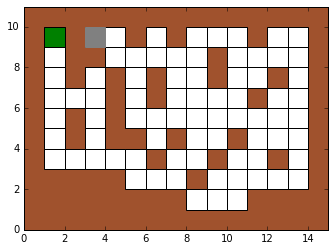

Unsolvable maze 1


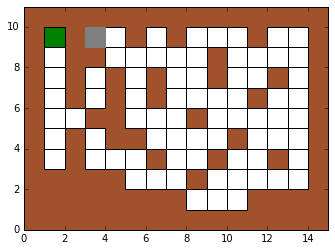

Maze 1


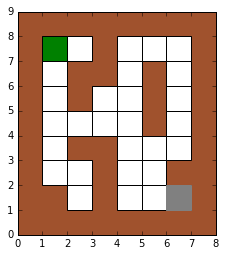

In [5]:
def maze1():
    return Maze([
        "########",
        "#X.#...#",
        "#.##.#.#",
        "#.#..#.#",
        "#....#.#",
        "#.##...#",
        "#..#..##",
        "##.#..@#",
        "########"
    ])



def maze2():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#...#.#....#..#",
        "#.#.#.........#",
        "#.#.##.#..#...#",
        "#.....#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

print("Maze 2")
maze2().draw()

def mazeUnsolvable1():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#.#.#.#....#..#",
        "#..##...#.....#",
        "#.#.##....#...#",
        "#.#...#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

print("Unsolvable maze 1")
mazeUnsolvable1().draw()

print("Maze 1")
maze1().draw()

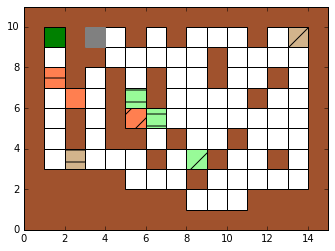

In [6]:
def maze3():
    return Maze([
        "###############",
        "#X#@.#.#...#.1#",
        "#.##.....#....#",
        "#A#.#.#..#..#.#",
        "#.a.#C#....#..#",
        "#.#.#0C.......#",
        "#.#.##.#..#...#",
        "#.B...#.2#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze3().draw()



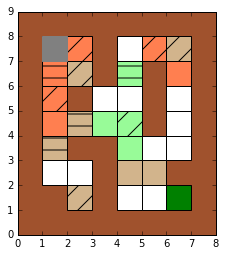

In [7]:
def maze4():
    return Maze([
        "########",
        "#@0#.01#",
        "#A1#C#a#",
        "#0#..#.#",
        "#aBc2#.#",
        "#B##c..#",
        "#..#bb##",
        "##1#..X#",
        "########"
    ])

maze4().draw()

In [31]:
import math
import queue
from pprint import pprint

def manhattan_distance(tile, exit):
    (x1, y1) = tile
    (x2, y2) = exit
    return abs(x1 - x2) + abs(y1 - y2)

def sum_tuples(a,b):
    (a1, a2) = a
    (b1, b2) = b
    return a1 + b1, a2 + b2

def subtract_tuples(a, b): # a - b
    (a1, a2) = a
    (b1, b2) = b
    return a1 - b1, a2 - b2

def available_moves(maze):
    moves = maze.available_moves()
    possible_moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    for move in possible_moves:
        if sum_tuples(move, maze.player_pos) == maze.exit_pos:
            moves += [move]
    return moves

def get_path(came_from, pos, maze):
    path = []
    position = pos
    str_path = ''
    while position != maze.player_pos:
        path += [position]
        position = came_from[position]

    for posit in path:
        (x,y) = posit
        maze.grid[y][x] = 'e'

    maze.draw()
    path.reverse()
    return path


def heuristic(maze):
    cost = 1
    came_from = {}    # path dict
    cost_so_far = {}  # cost so far at each node  
    maze_dict = {}    # dict of mazes as value and position as key
    frontier = queue.PriorityQueue()  # queue of places to explore, priority # is the heuristic value
    
    start_pos = maze.clone().player_pos
    came_from[maze.player_pos] = None
    cost_so_far[maze.player_pos] = 0
    maze_dict[maze.player_pos] = maze.clone()
    
    frontier.put((0,maze.player_pos))
    
    while not frontier.empty():
        pos = frontier.get()[1]   # sets the current position to the position at the top of the queue
        
        if pos == maze.exit_pos:  # if it's at the exit position, return path
            return get_path(came_from, pos, maze)        #print(pos, available_moves(maze_dict[pos]))
        
        for move in available_moves(maze_dict[pos]):   # gets the possible available moves (including the end pos!)
            new_maze = maze_dict[pos].clone()  # makes a copy of the current maze so you can advance w/o changing the previous maze

            if move == 'switch':
                new_maze.toggle()
                print("\ntoggled switch at", new_pos)
                new_maze.draw()
                print('\n-----------\n')
            else:
                if sum_tuples(move, pos) == maze.exit_pos:
                    return get_path(came_from, pos, maze)
                new_maze.move_player(move[0], move[1])      # move the player to the new position in the cloned maze

            new_pos = new_maze.player_pos
            new_cost = cost_so_far[pos] + cost  # the cost to get to this position

            if new_pos not in cost_so_far or new_cost < cost_so_far[new_pos]: # if the pos hasn't been explored yet, or if it's a less-costly path, futher explore this path
                cost_so_far[new_pos] = new_cost    # adds the pos to the cost dict

                frontier.put((new_cost + manhattan_distance(new_pos, maze.exit_pos), new_pos)) # adds the new_pos to the queue with cost + distance as the priority
                came_from[new_maze.player_pos] = pos        # add the old position to the came_from path
                maze_dict[new_maze.player_pos] = new_maze   # add the maze to the dict with the position
                
    maze.draw()
    return 'No solution'

    # Return a path which solves the maze: a sequence of elements like (dx,dy) or "switch".
    # You can use maze.exit_pos and query maze.grid[row][column] to investigate the maze.

You also have to be able to handle switch and door puzzles:

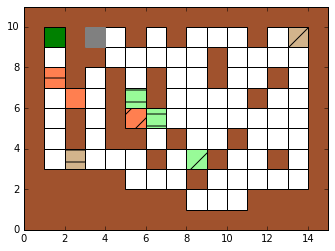


 RESULTS 


toggled switch at (8, 4)


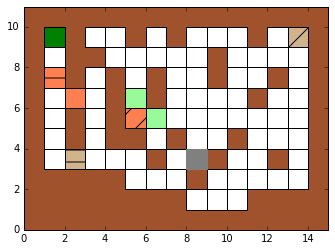


-----------


toggled switch at (13, 8)


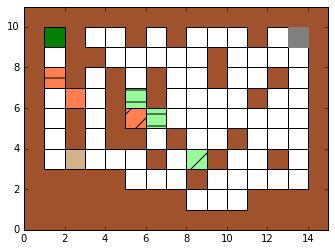


-----------



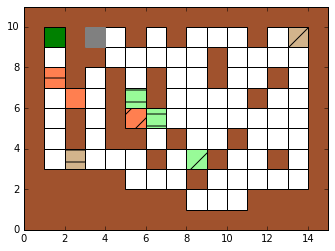

No solution




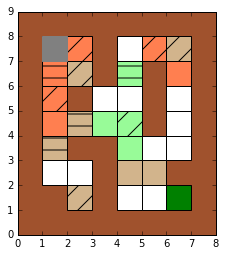


 RESULTS 


toggled switch at (2, 6)


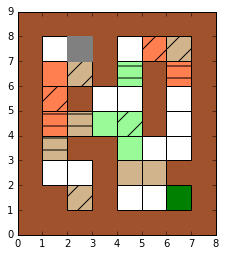


-----------


toggled switch at (2, 7)


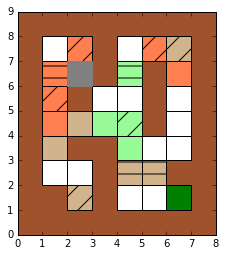


-----------



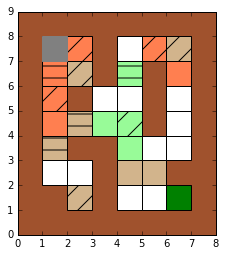

No solution


In [32]:
maze3().draw()
print("\n RESULTS \n")
print(heuristic(maze3()))
print('\n')
maze4().draw()
print("\n RESULTS \n")
print(heuristic(maze4()))

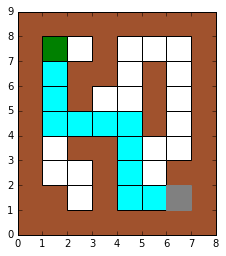

[(5, 1), (4, 1), (4, 2), (4, 3), (4, 4), (3, 4), (2, 4), (1, 4), (1, 5), (1, 6)] 




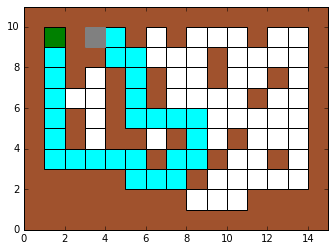

[(4, 9), (4, 8), (5, 8), (5, 7), (5, 6), (5, 5), (6, 5), (7, 5), (8, 5), (8, 4), (8, 3), (7, 3), (7, 2), (6, 2), (5, 2), (5, 3), (4, 3), (3, 3), (2, 3), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8)] 




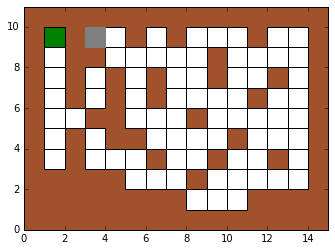

No solution


(None, '\n\n')

In [33]:
print(heuristic(maze1()),'\n\n')
print(heuristic(maze2()),'\n\n')
print(heuristic(mazeUnsolvable1())),'\n\n'

# Assignment 2

Once you have this working, write an agent which finds a policy for a "blind" puzzle using MCTS. "Blind" puzzles are just like the puzzles above, only (a) you don't get to see the whole puzzle or know the goal states in advance, and (b) some nodes are trap doors with a chance of dropping the player into a bottomless pit! Try different policies for deciding between exploit/explore and for doing rollouts and compare them.  Plot graphs on how learning improves with  more rollouts.

Of course, it should also be able to solve the earlier maze puzzles!

In [ ]:
class TreeNode:
        def __init__(self,val):
                self.value = val
                self.children = []
                self.parent = None

        def add_child(self, tn):
                self.children.append(tn)
                tn.parent = self
        

In [ ]:
def mcts(maze,iterations):
    # Return the expected value (a number between 0 for "player dead", 1 for "made it to the end")
    # for a budget of `iterations` rollouts.
    # Should also return the best found path (the one most likely to lead to success).
    # Here, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` rollouts, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)
    start_node = TreeNode(maze.player_pos)
    
    
    return ([], 0)

In [ ]:
def maze5():
    return Maze([
        "#######",
        "#@???X#",
        "#.....#",
        "#######"
    ])

maze5().draw()

def maze6():
    return Maze([
        "#######",
        "#@?!?X#",
        "#.???.#",
        "#.....#",
        "#######"
    ])

maze6().draw()

def maze7():
    return Maze([
        "########",
        "#@0#?01#",
        "#A1#C#a#",
        "#0#.?#!#",
        "#aBc2#.#",
        "#B##c.?#",
        "#.!#bb##",
        "##1#.?X#",
        "########"
    ])

maze7().draw()

# Assignment 3

Do assignment 2 again, but with reinforcement learning! Compare various approaches and parameters (e.g.\ different discounting rates, Sarsa vs Q-learning, etc) against your MCTS agents in terms of iterations required to reach certain levels of performance. Plot graphs showing how learning improves with more iterations. Print or draw out (at least some of) the state-value or action-value matrix.

Read as much as you care to of Sutton & Barto---[section 2](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node39.html) is especially useful.


In [ ]:
def rl(maze,iterations):
    # Return the best path (most likely to lead to success) along with its expected value and a validated value
    # for a budget of `iterations` experiments.
    # As above, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` experiments, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)

    return ([],0,0)

# Bonus Assignment

Make an adversary for the maze who is trying to eat the player. Try to get the best performing adversary possible!